In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [5]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [6]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=1000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

Metal device set to: Apple M1 Pro


2023-02-20 12:28:10.866298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 12:28:10.866412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 12:28:10.993349: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(1, 652, 224, 224, 1)


In [7]:
# Load model
experiments = ['imagery_sample_cnn_regression_NL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [8]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-20 12:28:17.931514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 1.95652679e-01]
 [-1.45927954e+01]
 [-4.32343912e+00]
 [-1.50304279e+01]
 [-1.48120155e+01]
 [-1.45593748e+01]
 [-9.37103748e+00]
 [-1.42924576e+01]
 [-1.43716087e+01]
 [-1.48644295e+01]
 [-1.51129627e+01]
 [-1.08495970e+01]
 [-1.49759493e+01]
 [-8.72588158e+00]
 [ 2.25740578e-02]
 [-1.47612505e+01]
 [-1.05343981e+01]
 [-1.52700520e+01]
 [-6.77726603e+00]
 [-3.69451344e-02]
 [-1.33057070e+01]
 [-6.54004002e+00]
 [-9.37103748e+00]
 [-7.57008982e+00]
 [-1.44840822e+01]
 [-1.36504869e+01]
 [-1.45401201e+01]
 [ 1.18269002e+00]
 [-1.52969046e+01]
 [-2.05888653e+00]
 [-1.14649630e+01]
 [-1.43248129e+01]
 [-1.42434683e+01]
 [-1.04321585e+01]
 [-1.42924576e+01]
 [-1.33412161e+01]
 [ 5.53504467e-01]
 [-7.77172446e-02]
 [-1.45820818e+01]
 [-6.77726603e+00]
 [-1.44840822e+01]
 [-1.50010633e+01]
 [ 1.65668368e-01]
 [-1.48165369e+01]
 [-1.44907312e+01]
 [ 4.34392244e-01]
 [-1.38200769e+01]
 [-1.49807396e+01]
 [ 2.03103181e-02]
 [ 4.52344492e-02]
 [-1.52286539e+01]
 [-1.48695421e+01]
 [-1.2526169

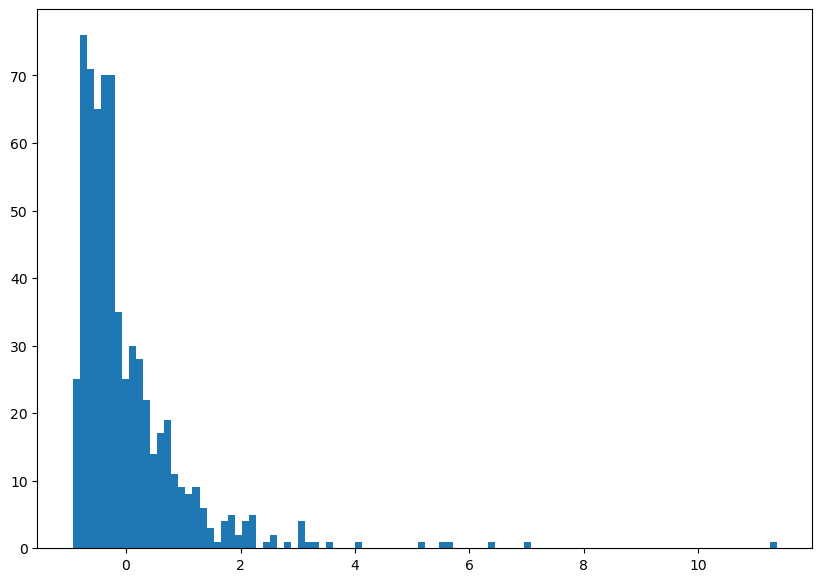

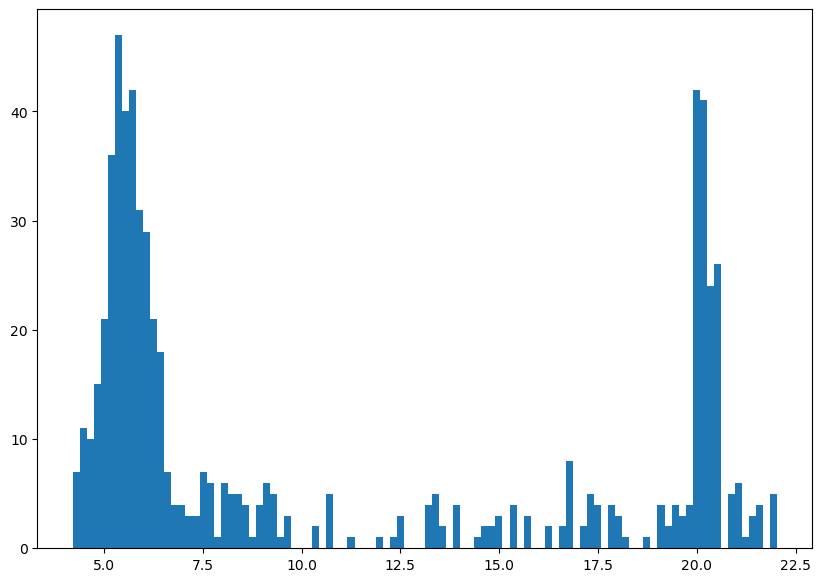

In [12]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()



r2 = pearsonr(y_true, y_preds)[0]

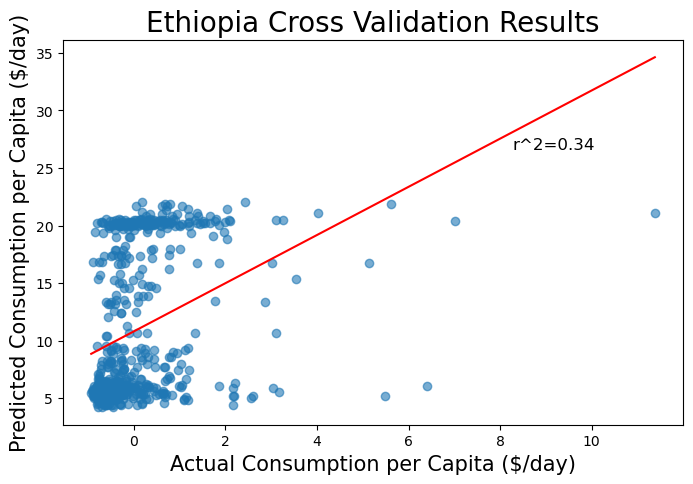

In [13]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()